# Collecting metrics for Magellanic Clouds science

This is a notebook that describes some of the preliminaries of running and creating metrics in MAF.  It borrows heavily from the notebooks listed in the [`sims_maf_contrib`](https://github.com/LSST-nonproject/sims_maf_contrib) tutorials.

In order for these imports to work, you need to have:

* installed the LSST software stack
* sourced the loadLSST setup file, e.g. `source loadLSST.bash`
* run `setup sims_maf` in the shell
* started your Jupyter server from the shell, e.g. `Juyter notebook`

In [1]:
from __future__ import print_function

import lsst.sims.maf
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

lsst.sims.maf.__version__

'2.13.0.sims-33-gd3cdcf88'

Metrics are computed against OpSim simulations, the outputs of which are stored in SQLite databases.  The latest simulation outputs are avaialable at http://astro-lsst-01.astro.washington.edu:8082.  They're described in https://community.lsst.org/t/january-2020-update-fbs-1-4-runs/4006.  In order to run metrics against a simulation, you need to have downloaded the associate .db file.  In this notebook, we use the simulation database available at http://astro-lsst-01.astro.washington.edu:8082/fbs_db/footprints/footprint_add_mag_cloudsv1.4_10yrs.db.

In [2]:
dbdir = '/Users/olsen/lsstRepos/mafdb/'
opsdb = db.OpsimDatabase(dbdir+'footprint_add_mag_cloudsv1.4_10yrs.db')
outDir = 'output_directory' #results from the metrics will be stored here
resultsDb = db.ResultsDb(outDir=outDir)


What information is in the OpSim output?  You can get the names of the columns in the database by running the `columnNames` method on `opsdb`.  The database populates these columns with information about every visit in the simulated cadence.  In order to access this information, we will need to issue a query against the database, as described below.

In [3]:
opsdb.columnNames

{'Proposal': ['proposalId', 'proposalName', 'proposalType'],
 'SummaryAllProps': ['observationId',
  'fieldRA',
  'fieldDec',
  'observationStartMJD',
  'flush_by_mjd',
  'visitExposureTime',
  'filter',
  'rotSkyPos',
  'numExposures',
  'airmass',
  'seeingFwhm500',
  'seeingFwhmEff',
  'seeingFwhmGeom',
  'skyBrightness',
  'night',
  'slewTime',
  'visitTime',
  'slewDistance',
  'fiveSigmaDepth',
  'altitude',
  'azimuth',
  'paraAngle',
  'cloud',
  'moonAlt',
  'sunAlt',
  'note',
  'fieldId',
  'proposalId',
  'block_id',
  'observationStartLST',
  'rotTelPos',
  'moonAz',
  'sunAz',
  'sunRA',
  'sunDec',
  'moonRA',
  'moonDec',
  'moonDistance',
  'solarElong',
  'moonPhase'],
 'info': ['index', 'Parameter', 'Value']}

As described in the sims_maf_contrib Introduction notebook, to run a metric against OpSim output, you need to:
* specify what you want to measure (referred to as the `metric`), e.g. 5-sigma depth
* specify how you want to project the output (referred to as a `slicer`), e.g. a map of the metric on the sky, or a one-dimensional vector ordered by time of observation, or a single number over the whole survey
* specify the subset of the OpSim output that you want to consider (referred to as a `constraint`), e.g. only output for visits in r-band.

Once these are defined, you collect them into a `MetricBundle`, assemble a dictionary (`bundledict`) describing all of yuor `MetricBundles`, associate your `bundledict` with the input simulation database and output results database through a `MetricBundleGroup`, and use the `MetricBundleGroup` to run your metric.  Following the Introduction notebook, here's an example that returns the lowest airmass at which r-band observations were made at each point in the sky, at roughly 1-degree resolution, using the footprint_add_mag_cloudsv1.4_10yrs simulation output:

In [4]:
# metric = the "maximum" of the "airmass" for each group of visits in the slicer
metric1 = metrics.MinMetric('airmass')

# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
slicer1 = slicers.HealpixSlicer(nside=64)

# sqlconstraint = the sql query (or 'select') that selects all visits in r band
sqlconstraint = 'filter = "r"'

# MetricBundle = combination of the metric, slicer, and sqlconstraint
minairmassSky = metricBundles.MetricBundle(metric1, slicer1, sqlconstraint)

# Our bundleDict will contain just this one metric
bundleDict = {'minairmassSky': minairmassSky}

# Group our bundleDict with the input simulation (opsdb) and location for string results (outDir, resultsDb)
group = metricBundles.MetricBundleGroup(
    bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Finally, run the metric against the simulation:

In [5]:
group.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['fieldDec', 'airmass', 'fieldRA']
Found 478175 visits
Running:  ['minairmassSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


MAF can plot the map of the minimum airmass, the histogram, and the power spectrum:

Plotting figures with "filter = "r"" constraint now.
monopole: 1.23194  dipole: lon: 80.3253, lat: 79.4989, amp: 0.242185
Plotting complete.


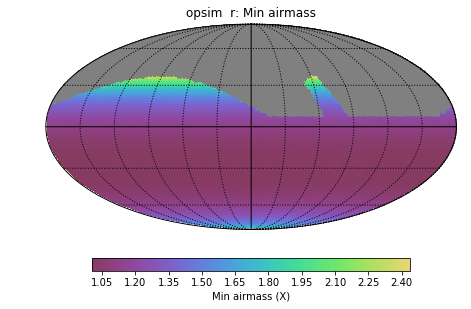

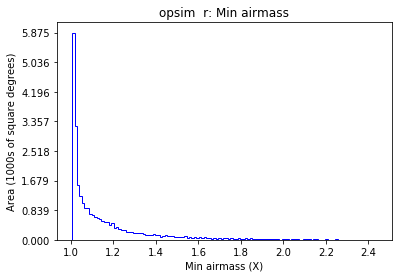

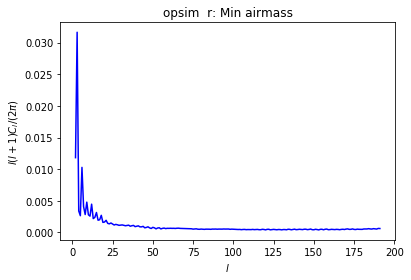

In [6]:
group.plotAll(closefigs=False)

MAF has lots of metric provided in its BaseMetric class.  You can get the list of names of them, as shown in the Writing a New Metric notebook, but they won't be very useful unless you can also see what they do.  Fortunately, the name of the module is also stored in the BaseMetric registry:

In [7]:
# List of provided metrics

for metric, module in zip(metrics.BaseMetric.registry.keys(), metrics.BaseMetric.registry.values()):
    print(metric, module)

PassMetric <class 'lsst.sims.maf.metrics.simpleMetrics.PassMetric'>
Coaddm5Metric <class 'lsst.sims.maf.metrics.simpleMetrics.Coaddm5Metric'>
MaxMetric <class 'lsst.sims.maf.metrics.simpleMetrics.MaxMetric'>
AbsMaxMetric <class 'lsst.sims.maf.metrics.simpleMetrics.AbsMaxMetric'>
MeanMetric <class 'lsst.sims.maf.metrics.simpleMetrics.MeanMetric'>
AbsMeanMetric <class 'lsst.sims.maf.metrics.simpleMetrics.AbsMeanMetric'>
MedianMetric <class 'lsst.sims.maf.metrics.simpleMetrics.MedianMetric'>
AbsMedianMetric <class 'lsst.sims.maf.metrics.simpleMetrics.AbsMedianMetric'>
MinMetric <class 'lsst.sims.maf.metrics.simpleMetrics.MinMetric'>
FullRangeMetric <class 'lsst.sims.maf.metrics.simpleMetrics.FullRangeMetric'>
RmsMetric <class 'lsst.sims.maf.metrics.simpleMetrics.RmsMetric'>
SumMetric <class 'lsst.sims.maf.metrics.simpleMetrics.SumMetric'>
CountUniqueMetric <class 'lsst.sims.maf.metrics.simpleMetrics.CountUniqueMetric'>
UniqueRatioMetric <class 'lsst.sims.maf.metrics.simpleMetrics.UniqueRa

If you want to see the documentation and code for a particular metric, try e.g.:

In [8]:
??lsst.sims.maf.metrics.simpleMetrics.MaxMetric